In this exercise, we need to model the distribution of X where X is a discrete r.v. with 2 dimensions.
Each dimension of X can take on 200 different discrete values.
We are given a 200 by 200 matrix where the (i, j)
position indicates the joint probability (X_1 = i, X_2 = j)

In [1]:
# Add to path so that we can import utils function
import sys
sys.path.insert(0, '/home/quan/hw/berkeley_cs294_158_deep_unsupervised_learning/')

In [2]:
from jax.experimental.optimizers import l2_norm
from jax.experimental.stax import Dense, Relu
from jax.experimental import stax
from utils.tensorboard import add_plot
from utils.np_utils import exp_normalize, one_hot
from tqdm import tqdm, trange
from tensorboardX import SummaryWriter
from jax import device_put, grad, jit, random, vmap
import matplotlib.pyplot as plt
import jax.numpy as np
import gtimer as gt
import time
import os
import os.path as osp
import numpy as onp
import scipy.stats as stats
from jax.experimental import optimizers


onp.random.seed(0)
%matplotlib inline

We begin by sampling a dataset of 100k (X_1, X_2) pairs
from the joint distribution
and will perform MLE to fit the empirical distribution.

We will use the first 60k as train set, the next 20k as validation set,
and the last 20k as test set.

In [3]:
distribution = onp.load('./distribution.npy',
                        allow_pickle=True)

# Computing pdata(x1)
pdata_x1 = onp.sum(distribution, axis=1)

# Sample x1
# multinomial returns
# an array of size (100000, 200)
# where each row is a one hot vector

x1s = onp.random.multinomial(1, pvals=pdata_x1, size=(100000, ))

# Sample x2
samples = onp.empty((100000, 2, 200), dtype=onp.float32)

for idx, x1 in enumerate(x1s):

    pdata_x2gx1 = distribution[onp.where(x1 == 1)[0][0]]

    pdata_x2gx1 = pdata_x2gx1 / onp.sum(pdata_x2gx1)

    x2 = onp.random.multinomial(1, pvals=pdata_x2gx1)

    samples[idx][0] = x1.astype(onp.float32)
    samples[idx][1] = x2.astype(onp.float32)

train_set = samples[:60000]
val_set = samples[60000:80000]
test_set = samples[80000:]

We can visualize the dataset by plotting a 2d histogram

/home/quan/miniconda3/envs/berkeley_dul/lib/python3.7/site-packages/jax/lib/xla_bridge.py:114: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


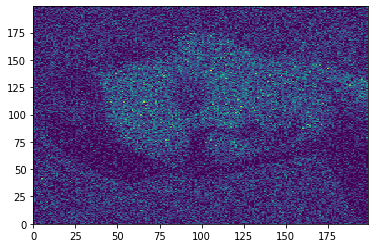

In [4]:
# TODO: move to util functions
def one_hot_to_int(data):
    """
    data is 2 dimensional array
    where the first dimension is batch dimension
    and the second is the one-hot encoding.
    returns a 1d array where the entry at index i
    is the int encoding of the one-hot vector 
    at row i in data.
    """
    return np.argmax(data, axis=1)

plt.hist2d(
    one_hot_to_int(train_set[:, 0, :]),
    one_hot_to_int(train_set[:, 1, :]),
    bins=200
)
plt.show()

That looks like a picture of Alan Turing! Looks like our code above is correct.

In part 1 of this question, we are asked to model the joint
probability by factoring it and modeling the individual cond. distribution separately,
Train p_theta(x) = p_thetax1(x1)p_thetax2(x2|x1).

We proceed by training p_thetax1 first

In [5]:
# Define the loss function

@jit
def get_prob(x, theta):
    # x is the one-hot encoding of the index of the sample
    # theta is a 1-d array which parameterizes the model

    exp_theta = np.exp(theta)

    num = np.sum(x * exp_theta)
    denum = np.sum(exp_theta)

    return num / denum


@jit
def get_neglogprob(x, theta):
    p = get_prob(x, theta)
    return - np.log(p)


@jit
def loss(theta, x):

    bget_neglogprob = vmap(get_neglogprob, in_axes=(0, None))

    neglogprob = bget_neglogprob(x, theta)

    return np.mean(neglogprob)

In [30]:
# Define the model and the optimizer and grad step funciton
num_class = 200
lr = 0.0003

theta_x1 = np.zeros((num_class), dtype=np.float32)

# Use optimizers to set optimizer initialization and update functions
opt_init, opt_update, get_params = optimizers.adam(step_size=lr)

opt_state = opt_init(theta_x1)

@jit
def step(i, opt_state, x):

    theta = get_params(opt_state)

    grads = grad(loss)(theta, x)

    return opt_update(i, grads, opt_state)

In [31]:
# Define the training loop

num_update = 30000
key = random.PRNGKey(0)
batch_size = 32
log_interval = 1000


# generate the mini batch idxes beforehand
all_minibatch_idxes = random.randint(key, shape=(num_update,
                                             batch_size,),
                                 minval=0, maxval=len(train_set))


def get_nll2(x, theta):
    p = get_prob(x, theta)
    return - np.log2(p)

bget_nll2 = jit(vmap(get_nll2, in_axes=(0, None)))


writer = SummaryWriter(
    osp.join('tensorboard', time.strftime("%Y-%m-%d %H:%M:%S")))


train_nlls = []
val_nlls = []

train_setx1 = train_set[:, 0, :]
val_setx1 = val_set[:, 0, :]


for update_idx in trange(num_update):

    idxes = all_minibatch_idxes[update_idx]

    minibatch = train_setx1[idxes]

    opt_state = step(update_idx, opt_state, minibatch)
    
    if update_idx % log_interval == 0:
    
        theta_x1 = get_params(opt_state)

        train_nll = bget_nll2(minibatch, theta_x1).mean()
        writer.add_scalar('NLL of train minibatch', onp.asarray(
                            train_nll), update_idx)
        train_nlls.append(train_nll)

        val_nll = bget_nll2(val_setx1, theta_x1).mean()

        writer.add_scalar('NLL of val set', onp.asarray(
                            val_nll), update_idx)
        val_nlls.append(val_nll)
        
        writer.flush()

100%|██████████| 30000/30000 [00:41<00:00, 727.78it/s]


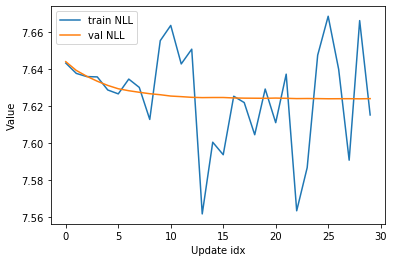

In [32]:
# Plot
plt.plot(train_nlls, label='train NLL')
plt.plot(val_nlls, label='val NLL')
plt.xlabel('Update idx')
plt.ylabel('Value')
plt.legend()
plt.show()

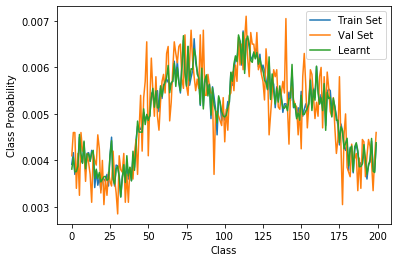

In [41]:
# Plot the learnt probability of each class 
# of x1 vs the empirical distribution

train_dist = onp.sum(train_setx1, axis=0)
train_dist = train_dist / onp.sum(train_dist)

val_dist = onp.sum(val_setx1, axis=0)
val_dist = val_dist / onp.sum(val_dist)

theta_x1 = get_params(opt_state)
normalized_theta = exp_normalize(theta_x1)

plt.plot(train_dist, label='Train Set')
plt.plot(val_dist, label='Val Set')

plt.plot(normalized_theta, label='Learnt')

plt.xlabel('Class')
plt.ylabel('Class Probability')
plt.legend()
plt.show()

From the plot above, we can see that we have managed to fit the empirical distribution of the train set well
and the learnt distribution generalizes to the val set. How about the test set?

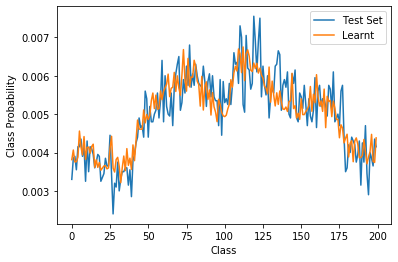

Test Set NLL 7.6202555


In [45]:
# Plot the learnt probability of each class 
# of x1 vs the empirical distribution

test_setx1 = test_set[:, 0, :]

test_dist = onp.sum(test_setx1, axis=0)
test_dist = test_dist / onp.sum(test_dist)

theta_x1 = get_params(opt_state)
normalized_theta = exp_normalize(theta_x1)

plt.plot(test_dist, label='Test Set')
plt.plot(normalized_theta, label='Learnt')

plt.xlabel('Class')
plt.ylabel('Class Probability')
plt.legend()
plt.show()

test_nll = bget_nll2(test_setx1, theta_x1).mean()
print('Test Set NLL', test_nll)

This is not perfect, but decent result nevertheless!